In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append("..") # Adds higher directory to our route_optimization.
from route_optimization.route_optimization_handler import RouteOptimizationHandler

Load the dataset

In [2]:
routes_df = pd.read_csv('../dataset/service_trips.csv', index_col=0)
np.random.seed(42)
routes_df = routes_df.sample(n=100)

Create route_optimizer object 

In [3]:
RESTRICTED_TIME = 480
DEADHEAD = 15
route_optimizer = RouteOptimizationHandler(routes_df=routes_df, restricted_time=RESTRICTED_TIME)

Fit the object - generate S and P matrices

In [4]:
%%time
route_optimizer.fit()
S = route_optimizer.get_neighbors_matrix()
P = route_optimizer.get_penalty_matrix()

Wall time: 7.12 s


### Generate random schedule

In [5]:
%%time
s_random = route_optimizer.get_random_schedule()

Wall time: 7.19 s


In [6]:
print('---Random Schedule---')
print(f'Valid Schedule: {route_optimizer._valid_schedule(schedule=s_random)}')
print('OpEx:', route_optimizer.get_schedule_OpEx(s_random))
print('Deadheads:', route_optimizer.get_schedule_OpEx(s_random) / DEADHEAD)
print('Num of Vehicles:', len(s_random))

---Random Schedule---
Valid Schedule: True
OpEx: 1215
Deadheads: 81.0
Num of Vehicles: 31


### Generate schedule using Beam Search

Clearing the covered trips for creating new schedule

In [7]:
route_optimizer.reset_C()

Setting $\beta$ = 10

In [8]:
beta = 10

In [9]:
%%time
s = route_optimizer.get_schedule(k=beta)

New Vehicle created len of 10 Took 52.58s
Covered 10.000% of the trips...
vehicle deadheads 0.0...
vehicle duration 480...
Num of vehicles 1...

New Vehicle created len of 7 Took 36.37s
Covered 17.000% of the trips...
vehicle deadheads 0.0...
vehicle duration 450...
Num of vehicles 2...

New Vehicle created len of 7 Took 22.11s
Covered 24.000% of the trips...
vehicle deadheads 0.0...
vehicle duration 480...
Num of vehicles 3...

New Vehicle created len of 7 Took 23.40s
Covered 31.000% of the trips...
vehicle deadheads 0.0...
vehicle duration 450...
Num of vehicles 4...

New Vehicle created len of 7 Took 14.78s
Covered 38.000% of the trips...
vehicle deadheads 0.0...
vehicle duration 450...
Num of vehicles 5...

New Vehicle created len of 6 Took 16.20s
Covered 44.000% of the trips...
vehicle deadheads 0.0...
vehicle duration 450...
Num of vehicles 6...

New Vehicle created len of 7 Took 9.99s
Covered 51.000% of the trips...
vehicle deadheads 0.0...
vehicle duration 450...
Num of vehicle

In [10]:
print('---Beam Search Schedule---')
print(f'Valid Schedule: {route_optimizer._valid_schedule(schedule=s)}')
print('OpEx:', route_optimizer.get_schedule_OpEx(schedule=s))
print('Deadheads:', route_optimizer.get_schedule_OpEx(schedule=s) / DEADHEAD)
print('Num of Vehicles:', len(s))

---Beam Search Schedule---
Valid Schedule: True
OpEx: 795
Deadheads: 53.0
Num of Vehicles: 22


### post hoc

In [48]:
schedules_by_iterations = {0: [[i] for i in routes_df.index]}
for idx,v in enumerate(s):
    last_s = schedules_by_iterations[idx].copy()
    [last_s.remove([trip]) for trip in v]
    last_s.append(v)
    schedules_by_iterations[idx+1] = last_s
    
random_schedules_by_iterations = {0: [[i] for i in routes_df.index]}
for idx,v in enumerate(s_random):
    last_s = random_schedules_by_iterations[idx].copy()
    [last_s.remove([trip]) for trip in v]
    last_s.append(v)
    random_schedules_by_iterations[idx+1] = last_s

In [111]:
def f(x, factor=1):
    return factor/(x)
fx_name = r'$f(x)=\frac{1}{x}$'

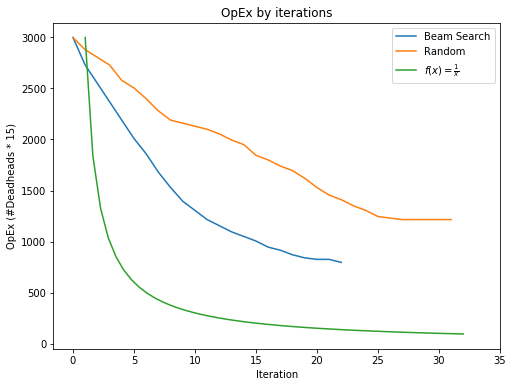

In [112]:
plt.figure(figsize=(8, 6))

x = list(schedules_by_iterations.keys())
y = [route_optimizer.get_schedule_OpEx(schedule=s) for s in schedules_by_iterations.values()]
x_random = list(random_schedules_by_iterations.keys())
y_random = [route_optimizer.get_schedule_OpEx(schedule=s) for s in random_schedules_by_iterations.values()]
plt.plot(x, y, label=r'Beam Search')
plt.plot(x_random, y_random, label=r'Random')

# using 101 steps results in in array including the value 0
factor_x=np.linspace(1,max(len(x), len(x_random)))
# f(0) = nan -> a nan value creates a gap
factor_y=f(factor_x, factor=len(route_optimizer.get_N())*2*DEADHEAD)
plt.plot(factor_x, factor_y, label=fx_name)

plt.legend(loc='upper right')
plt.ylabel('OpEx (#Deadheads * 15)')
plt.xlabel('Iteration')
plt.xticks(range(0,max(len(x), len(x_random))+5,5))
plt.yticks(np.arange(0, max(y)+500, step=500))
plt.title('OpEx by iterations')

plt.savefig('opex')
plt.show()

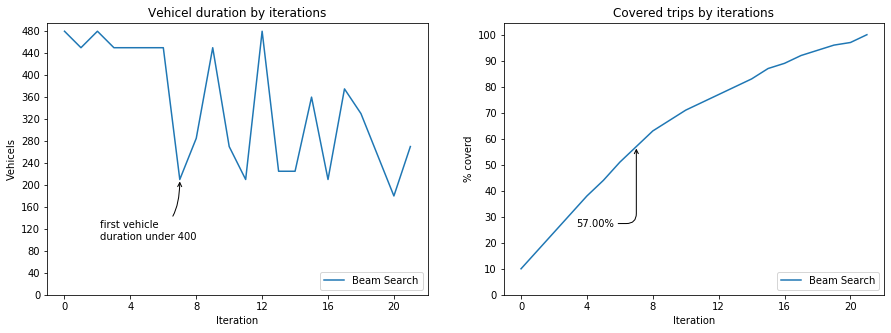

In [92]:
plt.figure(figsize=(15, 5))

x = range(len(s))
y = [route_optimizer._get_vehicle_duration(vehicle=v) for v in s]
plt.subplot(121)
plt.plot(x, y, label=r'Beam Search')

plt.annotate('first vehicle\nduration under 400',
            xy=(7, y[7]), xycoords='data',
            xytext=(-80, -60), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

plt.legend(loc='lower right')
plt.ylabel('Vehicels')
plt.xlabel('Iteration')
plt.xticks(np.arange(0, len(x), step=4))
plt.yticks(np.arange(0, RESTRICTED_TIME+40, step=40))
plt.title('Vehicel duration by iterations')

x = range(len(s))
y = [100*(len(v) / len(route_optimizer.get_N())) for v in s]
cumulative_y = np.cumsum(y)
plt.subplot(122)
plt.plot(x, cumulative_y, label=r'Beam Search')

plt.annotate(f'{cumulative_y[56]:0.2f}%',
            xy=(7,cumulative_y[7]), xycoords='data',
            xytext=(-60, -80), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=-180,angleB=90,rad=10"))


plt.legend(loc='lower right')
plt.ylabel('% coverd')
plt.xlabel('Iteration')
plt.xticks(np.arange(0, len(x), step=4))
plt.yticks(np.arange(0, 110, step=10))
plt.title('Covered trips by iterations')


plt.show()